# Coupling

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', font_scale=1.2)

# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

# Keep only Cz
data = data[0, :].astype(np.float64)
print(data.shape, np.round(data[0:5], 3))

(2161058,) [15.797 22.307 39.922 25.657 27.094]


In [2]:
# Load the hypnogram data
hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
print(hypno.shape, 'Unique values =', np.unique(hypno))

# Upsample to data
hypno = yasa.hypno_upsample_to_data(hypno=hypno, sf_hypno=1/30, data=data, sf_data=sf)

(720,) Unique values = [0 1 2 3 4]


c:\users\raphael\desktop\yasa\yasa\hypno.py:168: UserWarning: Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram (with last value) to match data.size.
  'data.size.' % dur_diff)


## Event-locked analyses

**Spindles detection**

In [3]:
sp = yasa.spindles_detect(data, sf, hypno, include=(2, 3), remove_outliers=True)
print(sp.shape)
sp.head()

(482, 12)


C:\Users\Raphael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage
0,585.54,586.09,586.38,0.84,59.682744,13.334660,2.256629,0.475648,12.957519,10.0,0.647059,2
1,598.09,598.62,599.52,1.43,79.858324,16.234394,2.377198,0.424400,12.888586,19.0,0.368056,2
2,604.37,604.73,605.08,0.71,60.636707,12.874629,2.222283,0.355090,12.648408,9.0,0.500000,2
3,622.93,623.53,624.39,1.46,144.871977,26.807843,2.651264,0.465681,12.768725,18.0,0.408163,2
4,655.06,655.50,655.86,0.80,47.939197,10.889576,2.148836,0.369696,13.328633,11.0,0.543210,2


In [4]:
# Get data centered around the most prominent peak of each spindle
events = yasa.get_sync_events(data, sf, detection=sp, center='Peak', time_before=1, time_after=1)
events

,Time,Event,Amplitude
0,-1.00,0,-26.614866
1,-0.99,0,-26.710604
2,-0.98,0,-29.008289
3,-0.97,0,-21.062124
4,-0.96,0,-21.445072
...,...,...,...
96877,0.96,481,-10.818273
96878,0.97,481,-0.574422
96879,0.98,481,3.638003
96880,0.99,481,2.010475


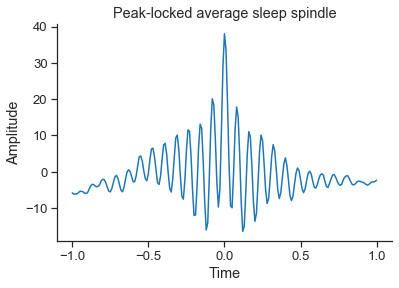

In [5]:
# Plot the peak-locked sleep spindle average across all detected spindles in NEM for this participant
events.groupby("Time")['Amplitude'].mean().plot(color=['tab:blue'])
plt.ylabel('Amplitude')
plt.title("Peak-locked average sleep spindle")
sns.despine()

**Slow oscillations amplitude**

In [6]:
# Filter slow-oscillations
data_so = mne.filter.filter_data(data, sf, 0.1, 1.25, verbose=0, h_trans_bandwidth=0.1, l_trans_bandwidth=0.1)

# Get filtered SO data centered around the most prominent peak of each spindle
events_so = yasa.get_sync_events(data_so, sf, detection=sp, center='Peak', time_before=1, time_after=1)
events = events.merge(events_so, on=['Time', 'Event'], suffixes=['_sp', '_so'])
events.rename(columns={'Amplitude_sp': 'Spindles', 'Amplitude_so': 'SO'}, inplace=True)

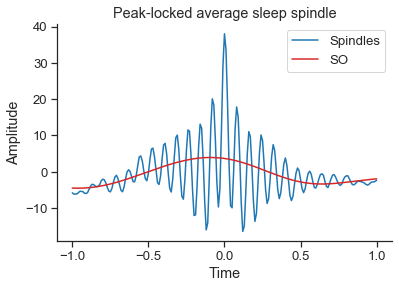

In [7]:
# Overlay spindles + slow-oscillations
events.groupby("Time").mean().plot(color=['tab:blue', 'tab:red'])
plt.ylabel('Amplitude')
plt.title("Peak-locked average sleep spindle")
sns.despine()

**Slow-oscillations phase**

In [8]:
from scipy.signal import hilbert
from scipy.fftpack import next_fast_len

# Extract instantaneous phase using Hilbert transform
n = data_so.size
nfast = next_fast_len(n)
inst_phase = np.angle(hilbert(data_so, N=nfast)[:n])

# Get SO phase centered around the most prominent peak of each spindle
events_phase = yasa.get_sync_events(inst_phase, sf, detection=sp, center='Peak', time_before=1, time_after=1)
events_phase.rename(columns={'Amplitude': "SO_phase"}, inplace=True)
events = events.merge(events_phase, on=['Time', 'Event'])
events.head()

,Time,Event,Spindles,SO,SO_phase
0,-1.00,0,-26.614866,-13.393822,-2.627925
1,-0.99,0,-26.710604,-12.862176,-2.604123
2,-0.98,0,-29.008289,-12.336220,-2.581127
3,-0.97,0,-21.062124,-11.818120,-2.559007
4,-0.96,0,-21.445072,-11.309553,-2.537843


In [9]:
# Find the average phase (in radians) at spindles most prominent peak
events.groupby("Time")["SO_phase"].agg(pg.circ_mean).loc[0]

0.5307643897664661

In [10]:
# A shortcut for all the steps above is to use:
sp = yasa.spindles_detect(data, sf, hypno, include=(2, 3), remove_outliers=True, coupling=True, freq_so=(0.1, 1.25))
circ_mean = pg.circ_mean(sp['SOPhase'])
circ_vectorlength = pg.circ_r(sp['SOPhase'])
print(f"Circular mean = {circ_mean:.3f}, vector length = {circ_vectorlength:.3f}")

Circular mean = 0.537, vector length = 0.097


C:\Users\Raphael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


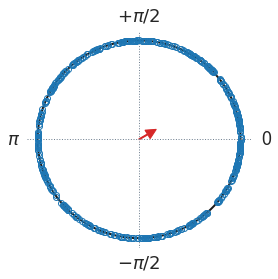

In [11]:
sns.set(font_scale=1.5, style='white')

# Note that the function plot_circmean is only implemented in Pingouin>=0.3.3
pg.plot_circmean(sp['SOPhase'], kwargs_markers=dict(ms=6));

*************************

## Data-driven PAC

To calculate formal phase-amplitude coupling, we'll be using the [tensorpac](https://etiennecmb.github.io/tensorpac/) package. Make sure to install it using: `pip install -U tensorpac`.

Here, rather than focusing on event-locked window (e.g. time around a spindles), we'll simply use epochs of 15-seconds of N2 sleep to measure a more formal phase-amplitude coupling (PAC) across a range of phase and amplitude frequencies.

In [12]:
# Segment N2 sleep into 15-seconds non-overlapping window
_, data_N2 = yasa.sliding_window(data[hypno == 2], sf, window=15)
# To speed up computation, keep only the first 50 epochs
data_N2 = data_N2[:50, :]
data_N2.shape

(50, 1500)

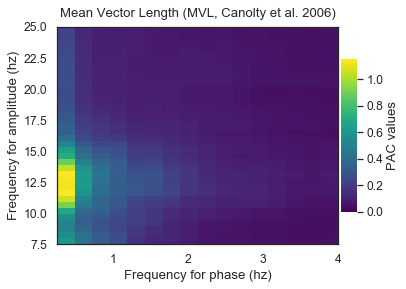

In [13]:
from tensorpac import Pac
sns.set(font_scale=1.1, style='white')

# Define a PAC object
p = Pac(idpac=(1, 3, 0),
        f_pha=np.arange(0.125, 4.25, 0.25), 
        f_amp=np.arange(7.25, 25.5, 0.5), 
        verbose='WARNING')

# Filter the data and extract PAC
xpac = p.filterfit(sf, data_N2, n_perm=50)
pval = p.pvalues

# Plot the Phase-Amplitude Coupling with p-values
p.comodulogram(xpac.mean(-1), title=str(p), vmin=0, plotas='imshow');

In [14]:
# Extract PAC values into a DataFrame
df_pac = pd.DataFrame(xpac.mean(-1), columns=p.xvec, index=p.yvec)
df_pac.columns.name = 'FreqPhase'
df_pac.index.name = 'FreqAmplitude'
df_pac.head(10).round(2)

FreqPhase,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00
FreqAmplitude,,,,,,,,,,,,,,,,
7.5,0.61,0.43,0.33,0.28,0.17,0.12,0.11,0.09,0.07,0.06,0.06,0.06,0.05,0.05,0.05,0.05
8.0,0.56,0.42,0.33,0.27,0.18,0.14,0.12,0.10,0.07,0.06,0.06,0.05,0.05,0.04,0.05,0.05
8.5,0.50,0.38,0.29,0.25,0.19,0.15,0.12,0.09,0.07,0.06,0.06,0.05,0.05,0.05,0.04,0.04
9.0,0.51,0.35,0.28,0.25,0.21,0.17,0.12,0.10,0.07,0.07,0.07,0.05,0.05,0.05,0.04,0.04
9.5,0.57,0.35,0.32,0.25,0.22,0.19,0.15,0.12,0.10,0.09,0.08,0.06,0.06,0.05,0.05,0.05
10.0,0.69,0.40,0.36,0.28,0.22,0.17,0.15,0.12,0.11,0.09,0.08,0.07,0.07,0.05,0.05,0.05
10.5,0.92,0.47,0.39,0.32,0.24,0.20,0.18,0.14,0.13,0.11,0.11,0.10,0.09,0.07,0.06,0.06
11.0,1.06,0.52,0.38,0.31,0.25,0.22,0.19,0.14,0.13,0.11,0.11,0.11,0.09,0.07,0.07,0.06
11.5,1.15,0.59,0.40,0.35,0.30,0.27,0.23,0.17,0.15,0.13,0.12,0.12,0.10,0.08,0.08,0.08
